In [1]:
projPath_load='/home/alvaro/notebook/jupyterenv/bin/TFM/DATA/dfA_n2_zone_aturat_index_realatur.csv'

In [2]:
projPath_save='/home/alvaro/notebook/jupyterenv/bin/TFM/DATA/'

In [3]:
month = '202206'
darsena = '_DM'

In [4]:
buffer_basin = 20 #m
buffer_dock = 30 #m
buffer_basin1 = 150 #m

min_points = 10

In [5]:
import numpy as np
import pandas as pd

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt

In [6]:
%matplotlib notebook

In [7]:
moll_map = gpd.read_file('/home/alvaro/notebook/jupyterenv/bin/TFM/22-23_Maniobres-20221022T161922Z-001/22-23_Maniobres/data/maps/MollsDarsenaMorrot_noTalo.shp')
dm_map = gpd.read_file('/home/alvaro/notebook/jupyterenv/bin/TFM/22-23_Maniobres-20221022T161922Z-001/22-23_Maniobres/data/maps/DarsenaMorrot.shp')

In [8]:
dm_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
dm_buffer = gpd.GeoDataFrame(geometry = dm_map.to_crs(32631).buffer(buffer_basin).to_crs(4326))
dm_buffer.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
dm_buffer_z2 = gpd.GeoDataFrame(geometry = dm_map.to_crs(32631).buffer(buffer_basin1).to_crs(4326))
dm_buffer_z2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
moll_buffer = gpd.GeoDataFrame(geometry = moll_map.to_crs(32631).buffer(buffer_dock, cap_style = 2,join_style = 2).to_crs(4326))

<IPython.core.display.Javascript object>


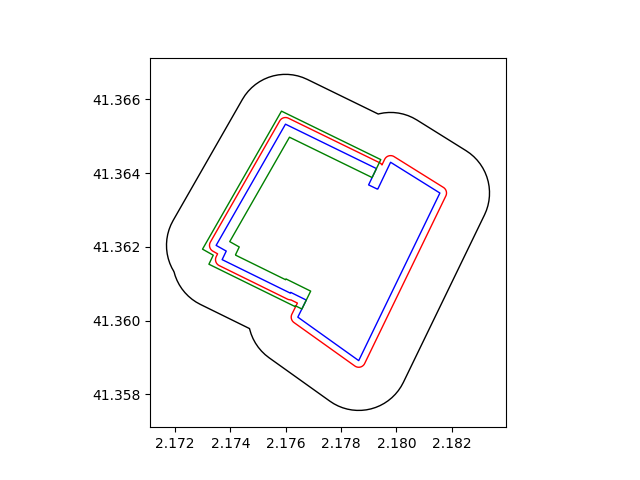

<AxesSubplot:>

In [12]:
fig, ax = plt.subplots()
dm_map.plot(ax = ax, fc = 'none', ec = 'blue')
dm_buffer.plot(ax = ax, fc = 'none', ec = 'red')
moll_buffer.plot(ax = ax, fc = 'none', ec = 'green')
dm_buffer_z2.plot(ax = ax, fc = 'none', ec = 'black')

# Load Data

In [13]:
dfA_n2=pd.read_csv(projPath_load)

In [14]:
len(dfA_n2)

57339

In [15]:
len(dfA_n2.loc[dfA_n2['real_atur']==1,:])

36734

In [17]:
dfA_n2.mmsi.unique()

array([247383500, 247383600, 247219400, 247383400, 247243600, 247383300,
       209115000, 210117000])

# TEST 1

In [16]:
dfA_n2.head()

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,draught,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur
0,2022-06-01 01:03:59,247383500,0,-6.0,34.0,2.17667,41.35834,26.1,25.0,2022-06-01,...,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0
1,2022-06-01 01:04:10,247383500,0,-7.0,33.0,2.17678,41.35849,25.9,25.0,2022-06-01,...,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0
2,2022-06-01 01:04:20,247383500,0,-7.0,33.0,2.17686,41.35864,25.5,24.0,2022-06-01,...,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0
3,2022-06-01 01:04:30,247383500,0,-8.0,33.0,2.17695,41.35878,25.3,24.0,2022-06-01,...,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0
4,2022-06-01 01:04:40,247383500,0,-9.0,32.0,2.17704,41.35892,25.1,23.0,2022-06-01,...,6.6,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0


In [20]:
dfA_n2['entsort'] = dfA_n2['entsort'].fillna('')

In [21]:
canvi1 = dfA_n2.entsort != dfA_n2.entsort.shift(1).fillna(dfA_n2.entsort.iloc[0])
canvi1

0        False
1        False
2        False
3        False
4        False
         ...  
57334    False
57335    False
57336    False
57337    False
57338    False
Name: entsort, Length: 57339, dtype: bool

In [22]:
dfA_n2['sgmt_test'] = canvi1.cumsum()
dfA_n2

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,sgmt_test
0,2022-06-01 01:03:59,247383500,0,-6.0,34.0,2.17667,41.35834,26.1,25.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,,0,0
1,2022-06-01 01:04:10,247383500,0,-7.0,33.0,2.17678,41.35849,25.9,25.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,,0,0
2,2022-06-01 01:04:20,247383500,0,-7.0,33.0,2.17686,41.35864,25.5,24.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,,0,0
3,2022-06-01 01:04:30,247383500,0,-8.0,33.0,2.17695,41.35878,25.3,24.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,,0,0
4,2022-06-01 01:04:40,247383500,0,-9.0,32.0,2.17704,41.35892,25.1,23.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57334,2022-06-30 23:01:02,247243600,5,0.0,57.0,2.17676,41.35868,205.0,205.0,2022-06-30,...,43.0,211.0,15.0,15.0,9351488,2,NaN,,0,280
57335,2022-06-30 23:01:03,247243600,5,0.0,57.0,2.17675,41.35865,203.9,205.0,2022-06-30,...,43.0,211.0,15.0,15.0,9351488,2,NaN,,0,280
57336,2022-06-30 23:01:05,247243600,5,0.0,57.0,2.17672,41.35860,203.9,206.0,2022-06-30,...,43.0,211.0,15.0,15.0,9351488,2,NaN,,0,280
57337,2022-06-30 23:01:10,247243600,5,0.0,59.0,2.17664,41.35848,205.0,206.0,2022-06-30,...,43.0,211.0,15.0,15.0,9351488,2,NaN,,0,280


In [27]:
dfA_n2.sgmt_test.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [24]:
# group the dataframe by the 'val' column and count the number of occurrences
grouped = dfA_n2.groupby('sgmt_test').size().reset_index(name='count')

# filter out rows where the count is 1
filtered = grouped[grouped['count'] > 1]

# merge the filtered rows with the original dataframe to get the desired result
result = pd.merge(dfA_n2, filtered, on='sgmt_test')

print(result)

                time_stamp       mmsi  status  turn  speed      lon       lat  \
0      2022-06-01 01:03:59  247383500       0  -6.0   34.0  2.17667  41.35834   
1      2022-06-01 01:04:10  247383500       0  -7.0   33.0  2.17678  41.35849   
2      2022-06-01 01:04:20  247383500       0  -7.0   33.0  2.17686  41.35864   
3      2022-06-01 01:04:30  247383500       0  -8.0   33.0  2.17695  41.35878   
4      2022-06-01 01:04:40  247383500       0  -9.0   32.0  2.17704  41.35892   
...                    ...        ...     ...   ...    ...      ...       ...   
57194  2022-06-30 23:01:02  247243600       5   0.0   57.0  2.17676  41.35868   
57195  2022-06-30 23:01:03  247243600       5   0.0   57.0  2.17675  41.35865   
57196  2022-06-30 23:01:05  247243600       5   0.0   57.0  2.17672  41.35860   
57197  2022-06-30 23:01:10  247243600       5   0.0   59.0  2.17664  41.35848   
57198  2022-06-30 23:01:12  247243600       5   0.0   59.0  2.17661  41.35843   

       course  heading     

In [26]:
result.sgmt_test.unique()

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280])

# TEST 2

In [38]:
import pandas as pd

# Crear el DataFrame
df = pd.DataFrame({'col': ['', '', 'ent', '', '', '', '', '', '', '', '', 'sort', '', '', '', '', '', 'ent', '', '', '', '', 'sort', '', '', '', '']})

# Crear una nueva columna 'col2' con NaN
df['col2'] = np.nan

# Rellenar los valores después de 'ent' con 'ent'
df.loc[df['col'].shift().eq('ent'), 'col2'] = 'ent'

# Rellenar los valores después de 'sort' con 'sort'
df.loc[df['col'].shift().eq('sort'), 'col2'] = 'sort'

# Propagar los valores hacia adelante
df['col2'] = df['col2'].ffill()

# Eliminar la columna 'col' original y renombrar 'col2' como 'col'


# Mostrar el resultado
print(df)


     col  col2
0          NaN
1          NaN
2    ent   NaN
3          ent
4          ent
5          ent
6          ent
7          ent
8          ent
9          ent
10         ent
11  sort   ent
12        sort
13        sort
14        sort
15        sort
16        sort
17   ent  sort
18         ent
19         ent
20         ent
21         ent
22  sort   ent
23        sort
24        sort
25        sort
26        sort


In [22]:
dfA_n2['test_entsort'] = np.nan
dfA_n2.loc[dfA_n2['entsort'].shift().eq('ent'), 'test_entsort'] = 'ent'
dfA_n2.loc[dfA_n2['entsort'].shift().eq('sort'), 'test_entsort'] = 'sort'
dfA_n2['test_entsort'] = dfA_n2['test_entsort'].ffill()


In [23]:
dfA_n2.head()

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
0,2022-06-01 01:03:59,247383500,0,-6.0,34.0,2.17667,41.35834,26.1,25.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0,NaN
1,2022-06-01 01:04:10,247383500,0,-7.0,33.0,2.17678,41.35849,25.9,25.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0,NaN
2,2022-06-01 01:04:20,247383500,0,-7.0,33.0,2.17686,41.35864,25.5,24.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0,NaN
3,2022-06-01 01:04:30,247383500,0,-8.0,33.0,2.17695,41.35878,25.3,24.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0,NaN
4,2022-06-01 01:04:40,247383500,0,-9.0,32.0,2.17704,41.35892,25.1,23.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,NaN,0,NaN


<IPython.core.display.Javascript object>


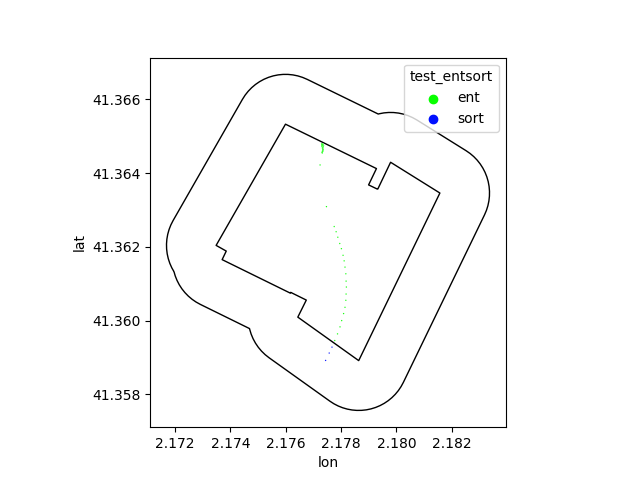

<AxesSubplot:xlabel='lon', ylabel='lat'>

In [43]:
fig, ax = plt.subplots()
dm_buffer_z2.plot(ax = ax, fc = 'none', ec = 'black')
dm_map.plot(ax = ax, fc = 'none', ec = 'black')
sns.scatterplot(data = dfA_n2.loc[289:480,:], x = 'lon',y = 'lat', s = 1, hue = 'test_entsort', palette = 'hsv')

In [40]:
dfA_n2.loc[(dfA_n2['entsort']=='ent') ,['test_entsort']] = 'ent'

In [41]:
dfA_n2.loc[(dfA_n2['entsort']=='sort') ,['test_entsort']] = 'sort'

# 247383500

In [44]:
dfAmmsi=dfA_n2.groupby('mmsi')

In [45]:
dfA1b1=dfAmmsi.get_group(247383500).copy()

In [46]:
dfA1b1.loc[(dfA1b1['entsort']=='ent')|(dfA1b1['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
289,2022-06-01 01:27:50,247383500,0,-7.0,2.0,2.17732,41.36455,9.4,119.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,0,NaN,ent,0,ent
478,2022-06-01 04:48:52,247383500,5,9.0,42.0,2.17767,41.35928,203.9,208.0,2022-06-01,...,116.0,122.0,27.0,7.0,9859557,2,NaN,sort,0,sort
6078,2022-06-03 10:12:48,247383500,0,0.0,1.0,2.17725,41.36457,345.3,118.0,2022-06-03,...,116.0,122.0,27.0,7.0,9859557,0,NaN,ent,0,ent
6538,2022-06-03 21:34:11,247383500,0,7.0,42.0,2.17779,41.35922,201.1,203.0,2022-06-03,...,116.0,122.0,27.0,7.0,9859557,2,NaN,sort,0,sort
11994,2022-06-08 01:00:38,247383500,0,-10.0,4.0,2.17745,41.36450,12.6,118.0,2022-06-08,...,116.0,122.0,27.0,7.0,9859557,0,NaN,ent,0,ent
12193,2022-06-08 04:43:38,247383500,5,10.0,44.0,2.17773,41.35921,204.0,207.0,2022-06-08,...,116.0,122.0,27.0,7.0,9859557,2,NaN,sort,0,sort
15592,2022-06-09 13:23:57,247383500,0,-8.0,4.0,2.17722,41.36459,30.2,115.0,2022-06-09,...,116.0,122.0,27.0,7.0,9859557,0,NaN,ent,0,ent
15875,2022-06-09 19:48:17,247383500,0,13.0,48.0,2.17761,41.35941,205.7,210.0,2022-06-09,...,116.0,122.0,27.0,7.0,9859557,2,NaN,sort,0,sort
31014,2022-06-13 07:30:26,247383500,0,-4.0,3.0,2.17730,41.36455,25.5,115.0,2022-06-13,...,116.0,122.0,27.0,7.0,9859557,0,NaN,ent,0,ent
31268,2022-06-13 11:46:52,247383500,0,9.0,36.0,2.17753,41.35941,206.8,208.0,2022-06-13,...,116.0,122.0,27.0,7.0,9859557,2,NaN,sort,0,sort


# TEST SEPARACION MANIOBRAS

In [96]:
def maniobras (dfA1b1):
    dfA1b1['time_stamp'] = pd.to_datetime(dfA1b1['time_stamp'])
    diff = dfA1b1['time_stamp'].diff().dt.total_seconds()/60
    dfA1b1['test_maniobras'] = (diff > 30).cumsum()

# 247383500

In [73]:
dfA1b1['time_stamp'] = pd.to_datetime(dfA1b1['time_stamp'])
diff = dfA1b1['time_stamp'].diff().dt.total_seconds()/60
dfA1b1['test_maniobras'] = (diff > 20).cumsum()

In [50]:
dfA1b1.test_maniobras.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

<IPython.core.display.Javascript object>


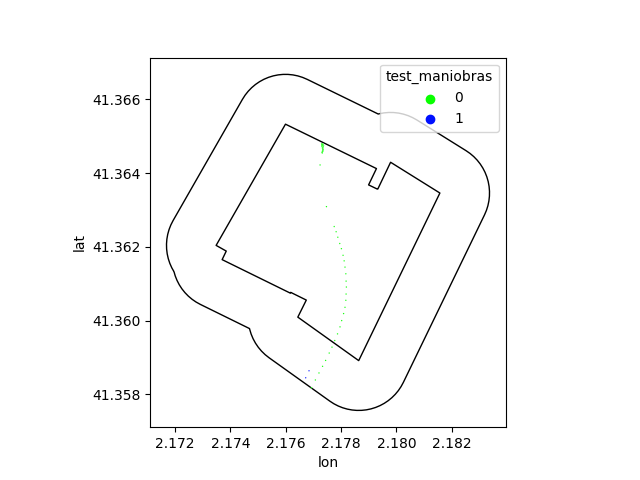

<AxesSubplot:xlabel='lon', ylabel='lat'>

In [64]:
fig, ax = plt.subplots()
dm_buffer_z2.plot(ax = ax, fc = 'none', ec = 'black')
dm_map.plot(ax = ax, fc = 'none', ec = 'black')
sns.scatterplot(data = dfA1b1.loc[289:5770,:], x = 'lon',y = 'lat', s = 1, hue = 'test_maniobras', palette = 'hsv')

In [68]:
diff.describe()

count    5889.000000
mean        7.231242
std       167.504545
min         0.000000
25%         0.066667
50%         0.166667
75%         0.183333
max      5943.150000
Name: time_stamp, dtype: float64

In [71]:
diff.nlargest(11)

11719    5943.150000
56461    5684.666667
30754    4996.816667
38307    4362.216667
46602    4043.250000
40954    3524.116667
5769     3170.750000
32992    2603.366667
49969    2123.300000
15356    1939.166667
50428       6.066667
Name: time_stamp, dtype: float64

In [125]:
dfmb = dfA1b1.groupby(['test_maniobras', 'real_atur'])

In [128]:
def tall_maniobras (df):
    result = df.agg({'time_stamp': ['first', 'last']}).loc[[1, 3]]

In [129]:
dfmb.apply(tall_maniobras)

ValueError: no results

# 247383600

In [77]:
dfA1b2=dfAmmsi.get_group(247383600).copy()
dfA1b2.loc[(dfA1b2['entsort']=='ent')|(dfA1b2['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
683,2022-06-01 07:05:46,247383600,0,-4.0,3.0,2.17728,41.36456,5.0,118.0,2022-06-01,...,127.0,111.0,30.0,4.0,9859569,0,NaN,ent,0,ent
2614,2022-06-02 00:16:25,247383600,5,3.0,42.0,2.17766,41.35941,204.2,206.0,2022-06-02,...,127.0,111.0,30.0,4.0,9859569,2,NaN,sort,0,sort
9728,2022-06-06 07:14:58,247383600,0,-8.0,5.0,2.17731,41.36455,322.7,116.0,2022-06-06,...,127.0,111.0,30.0,4.0,9859569,0,NaN,ent,0,ent
9921,2022-06-06 10:55:08,247383600,0,6.0,46.0,2.17756,41.35928,203.5,207.0,2022-06-06,...,127.0,111.0,30.0,4.0,9859569,2,NaN,sort,0,sort
12398,2022-06-08 07:11:43,247383600,0,5.0,3.0,2.17736,41.36453,336.6,118.0,2022-06-08,...,127.0,111.0,30.0,4.0,9859569,0,NaN,ent,0,ent
14331,2022-06-08 12:25:34,247383600,0,-6.0,31.0,2.17743,41.35944,206.1,205.0,2022-06-08,...,127.0,111.0,30.0,4.0,9859569,2,NaN,sort,0,sort
20292,2022-06-11 13:39:45,247383600,0,13.0,4.0,2.17726,41.36458,43.0,119.0,2022-06-11,...,127.0,111.0,30.0,4.0,9859569,0,NaN,ent,0,ent
20547,2022-06-11 18:27:11,247383600,0,4.0,46.0,2.17730,41.35959,207.2,207.0,2022-06-11,...,127.0,111.0,30.0,4.0,9859569,2,NaN,sort,0,sort
31796,2022-06-14 06:45:47,247383600,0,0.0,5.0,2.17727,41.36457,24.2,119.0,2022-06-14,...,127.0,111.0,30.0,4.0,9859569,0,NaN,ent,0,ent
32001,2022-06-14 11:27:43,247383600,0,7.0,51.0,2.17750,41.35949,201.9,205.0,2022-06-14,...,127.0,111.0,30.0,4.0,9859569,2,NaN,sort,0,sort


In [78]:
maniobras(dfA1b2)
dfA1b2.test_maniobras.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

# 247219400

In [79]:
dfA1b3=dfAmmsi.get_group(247219400).copy()
dfA1b3.loc[(dfA1b3['entsort']=='ent')|(dfA1b3['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
1213,2022-06-01 21:54:37,247219400,0,0.0,6.0,2.17530,41.36388,267.0,28.0,2022-06-01,...,20.0,234.0,15.0,15.0,9351476,0,NaN,ent,0,ent
2582,2022-06-02 01:38:47,247219400,0,0.0,61.0,2.17747,41.35950,201.0,202.0,2022-06-02,...,20.0,234.0,15.0,15.0,9351476,2,NaN,sort,0,sort
6647,2022-06-03 21:07:20,247219400,0,0.0,6.0,2.17531,41.36392,285.5,25.0,2022-06-03,...,20.0,234.0,15.0,15.0,9351476,0,NaN,ent,0,ent
7239,2022-06-04 00:55:46,247219400,0,0.0,65.0,2.17749,41.35942,202.0,202.0,2022-06-04,...,20.0,234.0,15.0,15.0,9351476,2,NaN,sort,0,sort
8781,2022-06-05 21:45:01,247219400,0,0.0,4.0,2.17525,41.36383,301.0,31.0,2022-06-05,...,20.0,234.0,15.0,15.0,9351476,0,NaN,ent,0,ent
9493,2022-06-06 22:15:37,247219400,0,0.0,63.0,2.17758,41.35943,201.2,204.0,2022-06-06,...,20.0,234.0,15.0,15.0,9351476,2,NaN,sort,0,sort
14434,2022-06-08 20:30:55,247219400,0,0.0,7.0,2.17526,41.36383,272.4,29.0,2022-06-08,...,20.0,234.0,15.0,15.0,9351476,0,NaN,ent,0,ent
14669,2022-06-08 23:49:16,247219400,0,127.0,66.0,2.17760,41.35936,201.3,204.0,2022-06-08,...,20.0,234.0,15.0,15.0,9351476,2,NaN,sort,0,sort
19804,2022-06-10 20:30:52,247219400,0,0.0,6.0,2.17530,41.36390,258.3,27.0,2022-06-10,...,20.0,234.0,15.0,15.0,9351476,0,NaN,ent,0,ent
20052,2022-06-11 00:25:47,247219400,0,0.0,66.0,2.17733,41.35942,199.2,201.0,2022-06-11,...,20.0,234.0,15.0,15.0,9351476,2,NaN,sort,0,sort


In [80]:
maniobras(dfA1b3)
dfA1b3.test_maniobras.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

# 247383400

In [90]:
dfA1b4=dfAmmsi.get_group(247383400).copy()
dfA1b4.loc[(dfA1b4['entsort']=='ent')|(dfA1b4['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
2898,2022-06-02 07:54:13,247383400,0,6.0,0.0,2.17740,41.36452,342.3,120.0,2022-06-02,...,127.0,111.0,30.0,4.0,9859545,0,NaN,ent,0,ent
5125,2022-06-02 14:03:53,247383400,0,7.0,41.0,2.17771,41.35921,200.4,205.0,2022-06-02,...,127.0,111.0,30.0,4.0,9859545,2,NaN,sort,0,sort
7906,2022-06-04 20:56:26,247383400,0,-7.0,2.0,2.17733,41.36454,7.4,119.0,2022-06-04,...,127.0,111.0,30.0,4.0,9859545,0,NaN,ent,0,ent
8598,2022-06-05 02:00:16,247383400,0,9.0,50.0,2.17761,41.35929,203.5,208.0,2022-06-05,...,127.0,111.0,30.0,4.0,9859545,2,NaN,sort,0,sort
14966,2022-06-09 01:51:28,247383400,0,3.0,0.0,2.17727,41.36456,314.8,121.0,2022-06-09,...,127.0,111.0,30.0,4.0,9859545,0,NaN,ent,0,ent
15350,2022-06-09 05:18:04,247383400,0,4.0,45.0,2.17782,41.35934,202.2,208.0,2022-06-09,...,127.0,111.0,30.0,4.0,9859545,2,NaN,sort,0,sort
16874,2022-06-10 13:44:41,247383400,0,6.0,2.0,2.17729,41.36455,358.3,120.0,2022-06-10,...,127.0,111.0,30.0,4.0,9859545,0,NaN,ent,0,ent
19695,2022-06-10 21:36:42,247383400,0,9.0,64.0,2.17751,41.35927,205.0,209.0,2022-06-10,...,127.0,111.0,30.0,4.0,9859545,2,NaN,sort,0,sort
32515,2022-06-15 01:49:14,247383400,0,-9.0,2.0,2.17725,41.36458,38.6,123.0,2022-06-15,...,127.0,111.0,30.0,4.0,9859545,0,NaN,ent,0,ent
32986,2022-06-15 05:25:36,247383400,0,10.0,49.0,2.17751,41.35938,197.5,204.0,2022-06-15,...,127.0,111.0,30.0,4.0,9859545,2,NaN,sort,0,sort


In [91]:
maniobras(dfA1b4)
dfA1b4.test_maniobras.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# 247243600

In [97]:
dfA1b5=dfAmmsi.get_group(247243600).copy()
dfA1b5.loc[(dfA1b5['entsort']=='ent')|(dfA1b5['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
5249,2022-06-02 18:56:04,247243600,0,0.0,5.0,2.17537,41.36400,280.1,32.0,2022-06-02,...,43.0,211.0,15.0,15.0,9351488,0,NaN,ent,0,ent
5759,2022-06-02 23:54:10,247243600,5,127.0,49.0,2.17738,41.35953,198.8,200.0,2022-06-02,...,43.0,211.0,15.0,15.0,9351488,2,NaN,sort,0,sort
8169,2022-06-04 21:45:51,247243600,0,0.0,4.0,2.17533,41.36393,267.3,31.0,2022-06-04,...,43.0,211.0,15.0,15.0,9351488,0,NaN,ent,0,ent
8658,2022-06-05 01:48:27,247243600,5,127.0,57.0,2.17731,41.35948,201.9,204.0,2022-06-05,...,43.0,211.0,15.0,15.0,9351488,2,NaN,sort,0,sort
11529,2022-06-07 18:02:35,247243600,0,0.0,3.0,2.17548,41.36413,274.5,23.0,2022-06-07,...,43.0,211.0,15.0,15.0,9351488,0,NaN,ent,0,ent
11709,2022-06-07 22:20:09,247243600,5,127.0,55.0,2.17738,41.35940,201.0,202.0,2022-06-07,...,43.0,211.0,15.0,15.0,9351488,2,NaN,sort,0,sort
15985,2022-06-09 18:53:22,247243600,0,0.0,8.0,2.17533,41.36393,234.1,31.0,2022-06-09,...,43.0,211.0,15.0,15.0,9351488,0,NaN,ent,0,ent
16184,2022-06-09 23:18:28,247243600,0,127.0,58.0,2.17731,41.35961,203.0,205.0,2022-06-09,...,43.0,211.0,15.0,15.0,9351488,2,NaN,sort,0,sort
20990,2022-06-11 19:58:30,247243600,0,0.0,7.0,2.17523,41.36382,284.0,30.0,2022-06-11,...,43.0,211.0,15.0,15.0,9351488,0,NaN,ent,0,ent
21807,2022-06-11 23:43:19,247243600,5,0.0,58.0,2.17735,41.35956,204.0,206.0,2022-06-11,...,43.0,211.0,15.0,15.0,9351488,2,NaN,sort,0,sort


In [98]:
maniobras(dfA1b5)
dfA1b5.test_maniobras.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [99]:
dfA1b5['time_stamp'] = pd.to_datetime(dfA1b5['time_stamp'])
diff = dfA1b5['time_stamp'].diff().dt.total_seconds()/60
dfA1b5['test_maniobras'] = (diff > 20).cumsum()

In [100]:
diff.nlargest(14)

41437    4048.800000
52721    4048.800000
32007    3998.333333
11422    3839.633333
8044     2737.416667
38837    2682.800000
20862    2666.433333
15881    2660.816667
48240    2657.000000
45183    2624.566667
36724    2613.633333
57078    2587.966667
52947      21.183333
41661       6.100000
Name: time_stamp, dtype: float64

# 247383300

In [103]:
dfA1b6=dfAmmsi.get_group(247383300).copy()
dfA1b6.loc[(dfA1b6['entsort']=='ent')|(dfA1b6['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
7450,2022-06-04 14:29:39,247383300,0,-11.0,3.0,2.17741,41.36451,29.2,125.0,2022-06-04,...,127.0,111.0,30.0,4.0,9859533,0,NaN,ent,0,ent
7633,2022-06-04 18:36:46,247383300,5,10.0,46.0,2.17762,41.35923,203.9,206.0,2022-06-04,...,127.0,111.0,30.0,4.0,9859533,2,NaN,sort,0,sort
11174,2022-06-07 07:47:17,247383300,0,-10.0,2.0,2.17730,41.36456,23.3,125.0,2022-06-07,...,127.0,111.0,30.0,4.0,9859533,0,NaN,ent,0,ent
11415,2022-06-07 11:55:52,247383300,0,15.0,43.0,2.17747,41.35948,202.9,203.0,2022-06-07,...,127.0,111.0,30.0,4.0,9859533,2,NaN,sort,0,sort
16391,2022-06-10 01:55:00,247383300,0,-7.0,2.0,2.17724,41.36457,30.5,126.0,2022-06-10,...,127.0,111.0,30.0,4.0,9859533,0,NaN,ent,0,ent
16667,2022-06-10 06:35:58,247383300,0,8.0,50.0,2.17740,41.35942,202.5,204.0,2022-06-10,...,127.0,111.0,30.0,4.0,9859533,2,NaN,sort,0,sort
20749,2022-06-11 21:10:55,247383300,0,-8.0,3.0,2.17734,41.36454,338.1,123.0,2022-06-11,...,127.0,111.0,30.0,4.0,9859533,0,NaN,ent,0,ent
21904,2022-06-12 00:11:02,247383300,0,8.0,48.0,2.17736,41.35947,204.4,207.0,2022-06-12,...,127.0,111.0,30.0,4.0,9859533,2,NaN,sort,0,sort
34015,2022-06-16 03:09:09,247383300,0,-10.0,3.0,2.17724,41.36457,9.6,127.0,2022-06-16,...,127.0,111.0,30.0,4.0,9859533,0,NaN,ent,0,ent
34190,2022-06-16 06:23:06,247383300,0,13.0,64.0,2.17768,41.35936,199.4,203.0,2022-06-16,...,127.0,111.0,30.0,4.0,9859533,2,NaN,sort,0,sort


In [104]:
maniobras(dfA1b6)
dfA1b6.test_maniobras.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# 209115000

In [105]:
dfA1b7=dfAmmsi.get_group(209115000).copy()
dfA1b7.loc[(dfA1b7['entsort']=='ent')|(dfA1b7['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
10057,2022-06-06 18:47:12,209115000,0,-8.0,6.0,2.17770,41.36440,337.7,115.0,2022-06-06,...,30.0,157.0,16.0,10.0,9261542,0,NaN,ent,0,ent
10949,2022-06-06 22:09:34,209115000,5,0.0,62.0,2.17743,41.35939,205.7,209.0,2022-06-06,...,30.0,157.0,16.0,10.0,9261542,2,NaN,sort,0,sort
30575,2022-06-13 18:39:10,209115000,0,-7.0,4.0,2.17762,41.36444,6.7,116.0,2022-06-13,...,30.0,157.0,16.0,10.0,9261542,0,NaN,ent,0,ent
30750,2022-06-13 22:18:06,209115000,5,9.0,60.0,2.17715,41.35945,203.4,204.0,2022-06-13,...,30.0,157.0,16.0,10.0,9261542,2,NaN,sort,0,sort
31408,2022-06-14 17:54:31,209115000,0,8.0,4.0,2.17767,41.36442,310.4,114.0,2022-06-14,...,30.0,157.0,16.0,10.0,9261542,0,NaN,ent,0,ent
31608,2022-06-14 22:18:19,209115000,5,-11.0,59.0,2.17705,41.35963,202.5,205.0,2022-06-14,...,30.0,157.0,16.0,10.0,9261542,2,NaN,sort,0,sort


In [107]:
dfA1b7['time_stamp'] = pd.to_datetime(dfA1b7['time_stamp'])
diff = dfA1b7['time_stamp'].diff().dt.total_seconds()/60
dfA1b7['test_maniobras'] = (diff > 20).cumsum()

In [109]:
maniobras(dfA1b7)
dfA1b7.test_maniobras.unique()

array([0, 1, 2])

In [111]:
dfA1b7.loc[(dfA1b7['entsort']=='ent')|(dfA1b7['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort,test_maniobras
10057,2022-06-06 18:47:12,209115000,0,-8.0,6.0,2.17770,41.36440,337.7,115.0,2022-06-06,...,157.0,16.0,10.0,9261542,0,NaN,ent,0,ent,0
10949,2022-06-06 22:09:34,209115000,5,0.0,62.0,2.17743,41.35939,205.7,209.0,2022-06-06,...,157.0,16.0,10.0,9261542,2,NaN,sort,0,sort,0
30575,2022-06-13 18:39:10,209115000,0,-7.0,4.0,2.17762,41.36444,6.7,116.0,2022-06-13,...,157.0,16.0,10.0,9261542,0,NaN,ent,0,ent,1
30750,2022-06-13 22:18:06,209115000,5,9.0,60.0,2.17715,41.35945,203.4,204.0,2022-06-13,...,157.0,16.0,10.0,9261542,2,NaN,sort,0,sort,1
31408,2022-06-14 17:54:31,209115000,0,8.0,4.0,2.17767,41.36442,310.4,114.0,2022-06-14,...,157.0,16.0,10.0,9261542,0,NaN,ent,0,ent,2
31608,2022-06-14 22:18:19,209115000,5,-11.0,59.0,2.17705,41.35963,202.5,205.0,2022-06-14,...,157.0,16.0,10.0,9261542,2,NaN,sort,0,sort,2


In [108]:
diff.nlargest(10)

30445    9855.433333
31276    1161.400000
30715      12.016667
30696       6.016667
31522       6.016667
31544       6.016667
31517       5.966667
10913       5.083333
30695       3.050000
30707       3.050000
Name: time_stamp, dtype: float64

# 210117000

In [112]:
dfA1b8=dfAmmsi.get_group(210117000).copy()
dfA1b8.loc[(dfA1b8['entsort']=='ent')|(dfA1b8['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_bow,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort
40225,2022-06-20 19:17:20,210117000,5,0.0,2.0,2.17840,41.36422,64.2,299.0,2022-06-20,...,116.0,23.0,13.0,4.0,7802794,0,NaN,ent,0,ent
40288,2022-06-20 21:34:22,210117000,5,127.0,55.0,2.17782,41.35910,195.5,209.0,2022-06-20,...,116.0,23.0,13.0,4.0,7802794,2,NaN,sort,0,sort


In [113]:
maniobras(dfA1b8)
dfA1b8.test_maniobras.unique()

array([0])

In [114]:
dfA1b8.loc[(dfA1b8['entsort']=='ent')|(dfA1b8['entsort']=='sort') ,:]

,time_stamp,mmsi,status,turn,speed,lon,lat,course,heading,day,...,to_stern,to_starboard,to_port,imo,zone,aturat,entsort,real_atur,test_entsort,test_maniobras
40225,2022-06-20 19:17:20,210117000,5,0.0,2.0,2.17840,41.36422,64.2,299.0,2022-06-20,...,23.0,13.0,4.0,7802794,0,NaN,ent,0,ent,0
40288,2022-06-20 21:34:22,210117000,5,127.0,55.0,2.17782,41.35910,195.5,209.0,2022-06-20,...,23.0,13.0,4.0,7802794,2,NaN,sort,0,sort,0
